# Acknowledgements

Notebook developed by Andrew Ferguson for the UChicago course MENG15100: Machine Learning and Artificial Intelligence for Molecular Discovery and Engineering.

# Artificial Neural Networks (ANNs)

Here we'll explore **artificial neural networks** as a prevalent and powerful technique that underpins many state-of-the-art (SOTA) supervised and unsupervised machine learning applications, including large language models (LLMs), image recgonition, image captioning, and generative molecular models.

# ANN step-by-step example

Let's start by analyzing an extremely simple fully-connected feedforward (FCFF) ANN with (i) two input neurons, (ii) one two-neuron hidden layer, and (iii) a single neuron output layer.

Let's build and visualize the network using the code below.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

np.random.seed(42)
def sigmoid(x): return 1/(1+np.exp(-x))
def draw_annotated_network(node_values, biases, weights, figsize=(7,6)):
    pos = {'x1':(0,1), 'x2':(0,-1), 'h1':(2,1), 'h2':(2,-1), 'y':(4,0)}
    bg_colors = {'x1':'deepskyblue', 'x2':'deepskyblue', 'h1':'palevioletred', 'h2':'palevioletred', 'y':'gold'}
    fig,ax = plt.subplots(figsize=figsize)
    G = nx.DiGraph()
    G.add_nodes_from(pos.keys())
    for i in ['x1','x2']:
        for h in ['h1','h2']:
            G.add_edge(i,h)
    for h in ['h1','h2']:
        G.add_edge(h,'y')
    for n in pos:
        val = node_values.get(n, '')
        val_str = f'{float(val):.3f}' if val not in ('','None') else ''
        node_label = f"{n}\n{val_str}" if val_str else f"{n}"
        circle = plt.Circle(pos[n], 0.40, color=bg_colors[n], ec='k', lw=2, zorder=3)
        ax.add_patch(circle)
        plt.text(pos[n][0], pos[n][1], node_label, fontweight='bold', fontsize=15, ha='center', va='center', zorder=4)
        if n in biases:
            plt.text(pos[n][0]-0.2, pos[n][1]+0.43, f"b={biases[n]:.3f}", color='slategray', fontsize=11, ha='center', va='bottom')
    def signcolor(w): return 'forestgreen' if w >= 0 else 'firebrick'
    for (u,v) in G.edges():
        w = weights[(u,v)]
        color = signcolor(w)
        dx, dy = pos[v][0]-pos[u][0], pos[v][1]-pos[u][1]
        mag = abs(w)
        ax.arrow(pos[u][0], pos[u][1], dx*0.7, dy*0.7, head_width=0.17, head_length=0.30, fc=color, ec=color, length_includes_head=True, linewidth=2+6*mag, alpha=0.65, zorder=2)
        offx = pos[u][0]+dx*0.5 + (0.13 if dy<0 else -0.13)
        offy = pos[u][1]+dy*0.5 + (0.13 if dx==0 else 0)
        plt.text(offx, offy, f"w={w:.3f}", color=color, fontsize=11, ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white',edgecolor='none', alpha=0.7))
    plt.axis('off'); plt.xlim(-1,5); plt.ylim(-2.2,2); plt.tight_layout(); plt.show()

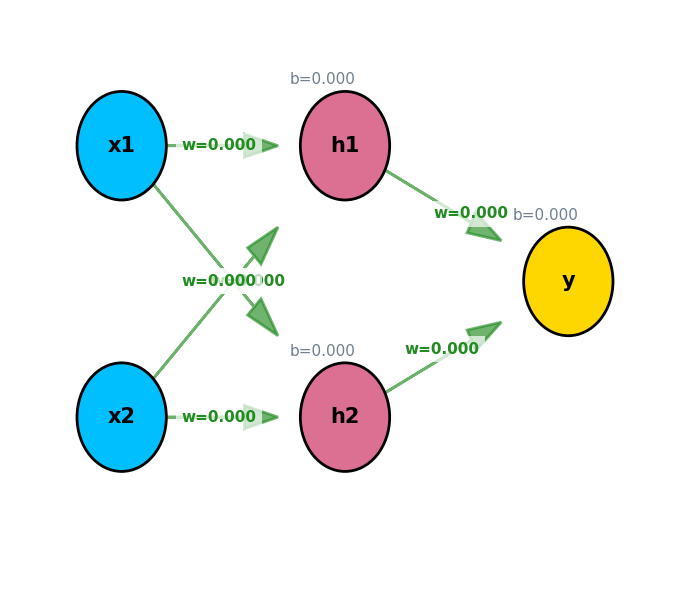

In [24]:
# Draw empty network (all vals = 0, no activations)
node_vals = {'x1': '', 'x2': '', 'h1': '', 'h2': '', 'y': ''}
bias_dict = {'h1': 0.0, 'h2': 0.0, 'y': 0.0}
weight_dict = {
    ('x1','h1'): 0.0,
    ('x2','h1'): 0.0,
    ('x1','h2'): 0.0,
    ('x2','h2'): 0.0,
    ('h1','y'): 0.0,
    ('h2','y'): 0.0
}
draw_annotated_network(node_vals, bias_dict, weight_dict)

What do you notice about the network?
* Do any of the nodes/neurons have any values yet?
* What are the current values of the weights and biases?
* Can you see how this network is designed to fit an (unknown) function $y = f(x_1,x_2)$?
* In a sense, the training data ``knows'' the function $f$ and it is our job as machine learning engineers to learn to approximate this function from the training data by **learning** appropriate network weights and biases.
* If, after we train, we find that the network does not give sufficiently accurate approximations to the training data, what could we do to improve the network expressibility?
* What theorem provides some assurance that the network should be able to fit arbitrary functional forms?

OK, let's proceed to conduct supervised training of this network to fit a single(!) training data point $Input: (x_1,x_2); Output: (y)$.

**N.B.** This is an intentionally overly simplified pedagogical example, usually we have many training points.

<br />

We will randomly initialize the weights and biases, then make a step-by-step **forward pass** through the network to see how well it predicts the target output.

We will then make a single **backward pass** through the network to apply a single round of **backpropagation** to update the network weights and biases by applying **gradient descent** of a loss function.

**N.B.** This is an intentionally overly simplified pedagogical example, usually we will make many backward passes over many training points.

<br />

Since we only have a single training point, we will not do so here, but usually we will split our data into **training-validation-test** partitions so we can apply **cross validation** to avoid network overfitting.

**N.B.** In general, performance on the **training set** will improve monotonically over the course of training. In the early stages of training, performance on the **validation set** will also improve, but then may start to degrade as we train longer due to **overfitting**. We typically look for the **training epoch** at which the validation error is minimized and use **early stopping** to avoid network overfitting.

<br />

We will adopt a simple **mean squared error (MSE)** loss function with which to evaluate the network performance and perform backpropagation.

$$
E = \frac{1}{2}(y_{pred} - y_{target})^2
$$

# First let's assign initial weights, biases, inputs, and target output

Inputs and target output:
$$
x_1 = 1.0 \qquad x_2 = 2.0 \qquad y_{target} = -0.5
$$

Weights & biases:
$$
w_{x1,h1}=0.200,\; w_{x2,h1}=0.400,\; b_{h1}=0.100 \\
w_{x1,h2}=0.300,\; w_{x2,h2}=0.700,\; b_{h2}=-0.300 \\
w_{h1,y}=0.600,\; w_{h2,y}=0.900,\; b_y=0.200
$$

Learning rate:
$$
\eta=0.2
$$

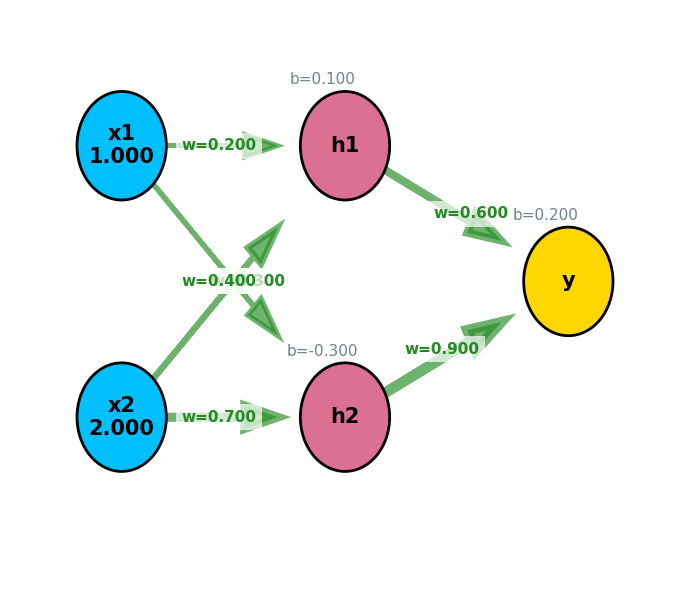

In [25]:
x1, x2 = 1.0, 2.0
y_target = -0.5
eta = 0.2
node_vals = {'x1':f'{x1:.3f}','x2':f'{x2:.3f}','h1':'','h2':'','y':''}
bias_dict = {'h1':0.1,'h2':-0.3,'y':0.2}
weight_dict = {('x1','h1'):0.2,('x2','h1'):0.4,('x1','h2'):0.3,('x2','h2'):0.7,('h1','y'):0.6,('h2','y'):0.9}
draw_annotated_network(node_vals, bias_dict, weight_dict)

OK, note that we have now filled in the input values $(x_1,x_2)$ within the two nodes in the input layer.

# Let's do a layer-by-layer **forward** pass

OK, so we know our inputs and we have initialized the input weights and biases, let's compute the network output and see how close it is to the target value given by the training data.

So we can consider $(x_1,x_2)$ and $y$ from the training data as an input-output pair defining a single **training example**. If the network produces an output very close to the target when we present that input, it is performing well. If it does not, then we need to update the weights and biases by **network training**.

### Hidden Layer Forward Math
$$
z_j = x_1 w_{x1,hj} + x_2 w_{x2,hj} + b_{hj} \\
h_j = \sigma(z_j) = \frac{1}{1 + e^{-z_j}}
$$

z1 = 1.000 * 0.200 + 2.000 * 0.400 + 0.100 = 1.100
z2 = 1.000 * 0.300 + 2.000 * 0.700 + -0.300 = 1.400
h1 = sigmoid(1.100) = 0.750
h2 = sigmoid(1.400) = 0.802


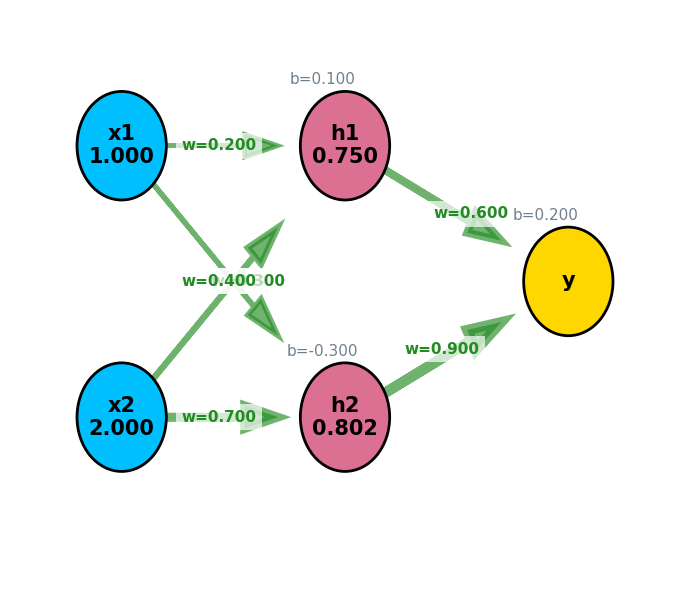

In [26]:
z1 = x1 * weight_dict[('x1','h1')] + x2 * weight_dict[('x2','h1')] + bias_dict['h1']
z2 = x1 * weight_dict[('x1','h2')] + x2 * weight_dict[('x2','h2')] + bias_dict['h2']
h1 = sigmoid(z1)
h2 = sigmoid(z2)
node_vals['h1'] = f'{h1:.3f}'
node_vals['h2'] = f'{h2:.3f}'
print(f"z1 = {x1:.3f} * {weight_dict[('x1','h1')]:.3f} + {x2:.3f} * {weight_dict[('x2','h1')]:.3f} + {bias_dict['h1']:.3f} = {z1:.3f}")
print(f"z2 = {x1:.3f} * {weight_dict[('x1','h2')]:.3f} + {x2:.3f} * {weight_dict[('x2','h2')]:.3f} + {bias_dict['h2']:.3f} = {z2:.3f}")
print(f"h1 = sigmoid({z1:.3f}) = {h1:.3f}")
print(f"h2 = sigmoid({z2:.3f}) = {h2:.3f}")
draw_annotated_network(node_vals, bias_dict, weight_dict)

OK, note that the hidden layer now has values assigned to the hidden values $(h_1,h_2)$ of the two hidden nodes.

The output layer has not yet had its value calculated. Let's do that now.

### Output Layer Forward Math
$$
z_y = h_1 w_{h1,y} + h_2 w_{h2,y} + b_y\\
y_{pred} = \sigma(z_y) = \frac{1}{1 + e^{-z_y}}
$$

z_y = 0.750 * 0.600 + 0.802 * 0.900 + 0.200 = 1.372
y_pred = sigmoid(1.372) = 0.798


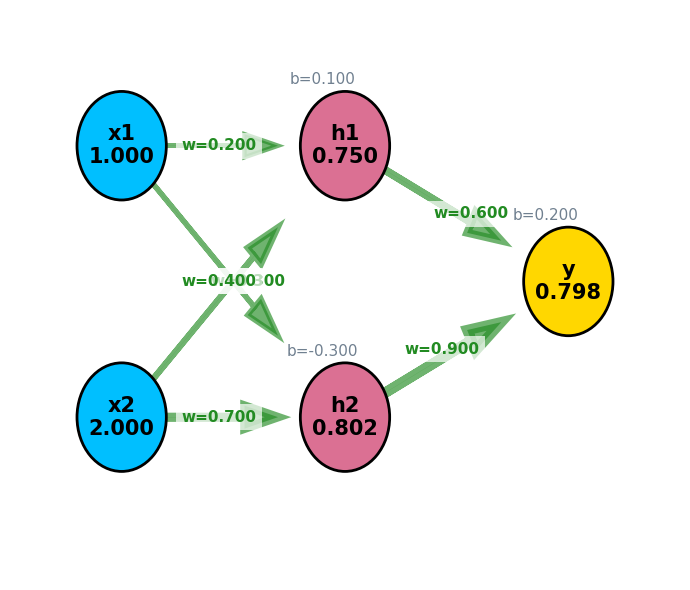

In [27]:
z_y = h1 * weight_dict[('h1','y')] + h2 * weight_dict[('h2','y')] + bias_dict['y']
y_pred = sigmoid(z_y)
node_vals['y'] = f'{y_pred:.3f}'
print(f"z_y = {h1:.3f} * {weight_dict[('h1','y')]:.3f} + {h2:.3f} * {weight_dict[('h2','y')]:.3f} + {bias_dict['y']:.3f} = {z_y:.3f}")
print(f"y_pred = sigmoid({z_y:.3f}) = {y_pred:.3f}")
draw_annotated_network(node_vals, bias_dict, weight_dict)

OK, now the output layer has it's value computed. This completes the forward pass.

# Loss Function

Remember our loss function (aka error fucntion) we will use to evaluate the network performance:

$$
E = \frac{1}{2}(y_{pred} - y_{target})^2
$$

Let's run that calculation to see how well the network performed with the random initial weights and biases.

In [28]:
E = 0.5 * (y_pred-y_target)**2
print(f"E = 0.5 * ({y_pred:.3f} - {y_target:.3f})^2 = {E:.5f}")

E = 0.5 * (0.798 - -0.500)^2 = 0.84204


Not so great! Looks like we need to use **backpropagation** to update the network parameters (i.e., the weights and biases) to get the output to be closer to the target value. This is network training!

# Let's do a layer-by-layer **backward** pass

### First Recall the Forward Pass Math Expressions

The output \$y_{pred}\$ is computed by:

$$
y_{pred} = \sigma(z_y) = \frac{1}{1 + e^{-z_y}}
$$

where

$$
z_y = h_1 w_{h1,y} + h_2 w_{h2,y} + b_y
$$

where

$$
h_j = \sigma(z_j) = \frac{1}{1 + e^{-z_j}}
$$

where

$$
z_1 = x_1 w_{x1,h1} + x_2 w_{x2,h1} + b_{h1} \\
z_2 = x_1 w_{x1,h2} + x_2 w_{x2,h2} + b_{h2}
$$

<br />

**Phew!** This is a long neseted set of equations that take us all the way from the output back through the network to its inputs. However ugly it is, it's nothing more than one very long equation and its gradients with respect to the various parameters (i.e., network weights and biases can be computed using the **chain rule**).

### The Loss Function

Once we have $y_{pred}$, it is easy to compute the loss function:

$$
E = \frac{1}{2} \left( y_{pred} - y_{target} \right)^2
$$

### Output Layer Weight and Bias Updates

To update the weights and biases on the single node in the output layer \$w_{h1,y}\$, \$w_{h2,y}\$, and \$b_y\$ we will use **backpropagation**. Remember, all that backprop does is ask the loss function how sensitive it is to small changes in each of the network weight and bias parameters.

We compute the **gradient in the loss function with respect to the network parameters** and then take a small step downhill in the loss function surface.

The size of the step downhill is controlled by the **learning rate** $\eta$.

So, we need to compute the gradients \$ \frac{\partial E}{\partial w_{h1,y}} \$, \$ \frac{\partial E}{\partial w_{h2,y}} \$, and \$ \frac{\partial E}{\partial b_y} \$ in order to figure out how to take a step downhill in each of these parameters.

Since \$E\$ is a function of \$y_{pred}\$, which is a function of \$z_y\$, which is a function of \$w_{h1,y}\$, \$w_{h2,y}\$, and \$b_y\$, we need to use the **chain rule**:

<br />

$$
\frac{\partial E}{\partial w_{h1,y}} =
\frac{\partial E}{\partial y_{pred}} \cdot
\frac{\partial y_{pred}}{\partial z_y} \cdot
\frac{\partial z_y}{\partial w_{h1,y}}
$$


$$
\frac{\partial E}{\partial w_{h2,y}} =
\frac{\partial E}{\partial y_{pred}} \cdot
\frac{\partial y_{pred}}{\partial z_y} \cdot
\frac{\partial z_y}{\partial w_{h2,y}}
$$

$$
\frac{\partial E}{\partial b_y} =
\frac{\partial E}{\partial y_{pred}} \cdot
\frac{\partial y_{pred}}{\partial z_y} \cdot
\frac{\partial z_y}{\partial b_y}
$$

<br />

Let's collect all the forward pass and loss function equations here:

- $ E = \frac{1}{2} \left( t - y_{pred} \right)^2 $
- $ y_{pred} = \sigma(z_y) = \frac{1}{1 + e^{-z_y}} $
- $ z_y = h_1 w_{h1,y} + h_2 w_{h2,y} + b_y $
- $ h_j = \sigma(z_j) = \frac{1}{1 + e^{-z_j}} $
- $ z_1 = x_1 w_{x1,h1} + x_2 w_{x2,h1} + b_{h1} $
- $ z_2 = x_1 w_{x1,h2} + x_2 w_{x2,h2} + b_{h2} $

<br />

Now, let's take the derivatives that we need:

- $ \frac{\partial E}{\partial y_{pred}} = y_{pred} - t $
- $ \frac{\partial y_{pred}}{\partial z_y} = y_{pred}(1 - y_{pred}) $
- $ \frac{\partial z_y}{\partial w_{h1,y}} = h_1 $
- $ \frac{\partial z_y}{\partial w_{h2,y}} = h_2 $
- $ \frac{\partial z_y}{\partial b_y} = 1 $

The second one involving the derivative of the sigmoid function is a little more involved - here's the step-by-step:

$
\frac{d y_{pred}}{d z_y}
$

$
=\frac{d}{d z_y} \left( \frac{1}{1 + e^{-z_y}} \right )
$

$
= \frac{e^{-z_y}}{(1 + e^{-z_y})^2}
$ (quotient rule)

$
= \frac{1}{1 + e^{-z_y}} \cdot \frac{e^{-z_y}}{1 + e^{-z_y}}
$

$
= \frac{1}{1 + e^{-z_y}} \cdot \left(1 - \frac{1}{1 + e^{-z_y}}\right)
$

$
= y_{pred}(1 - y_{pred})
$


<br />

Now, putting it all together:

$$
\frac{\partial E}{\partial w_{h1,y}} = (y_{pred} - t) \cdot y_{pred}(1-y_{pred}) \cdot h_1
$$

$$
\frac{\partial E}{\partial w_{h2,y}} = (y_{pred} - t) \cdot y_{pred}(1-y_{pred}) \cdot h_2
$$

$$
\frac{\partial E}{\partial b_y} = (y_{pred} - t) \cdot y_{pred}(1-y_{pred})
$$

<br />

For simplicity, we can define:

$$\delta_y = (y_{pred} - t) \cdot y_{pred}(1-y_{pred})$$

and write compactly as:

$$
\frac{\partial E}{\partial w_{h1,y}} = \delta_y\, h_1 \\
\frac{\partial E}{\partial w_{h2,y}} = \delta_y\, h_2 \\
\frac{\partial E}{\partial b_y} = \delta_y
$$

<br />

So our backprop update rules:

$$
w_{h1,y}^{new} = w_{h1,y} - \eta \frac{\partial E}{\partial w_{h1,y}} \\
w_{h2,y}^{new} = w_{h2,y} - \eta \frac{\partial E}{\partial w_{h2,y}} \\
b_y^{new} = b_y - \eta \frac{\partial E}{\partial b_y}
$$

become:

$$
w_{h1,y}^{new} = w_{h1,y} - \eta \delta_y\, h_1 \\
w_{h2,y}^{new} = w_{h2,y} - \eta \delta_y\, h_2 \\
b_y^{new} = b_y - \eta \delta_y
$$


delta_y = (0.798 - -0.500) * 0.798 * (1 - 0.798) = 0.209402
w_h1y_new = 0.600 - 0.200 * (0.209402 * 0.750) = 0.569
w_h2y_new = 0.900 - 0.200 * (0.209402 * 0.802) = 0.866
b_y_new = 0.200 - 0.200 * 0.209402 = 0.158


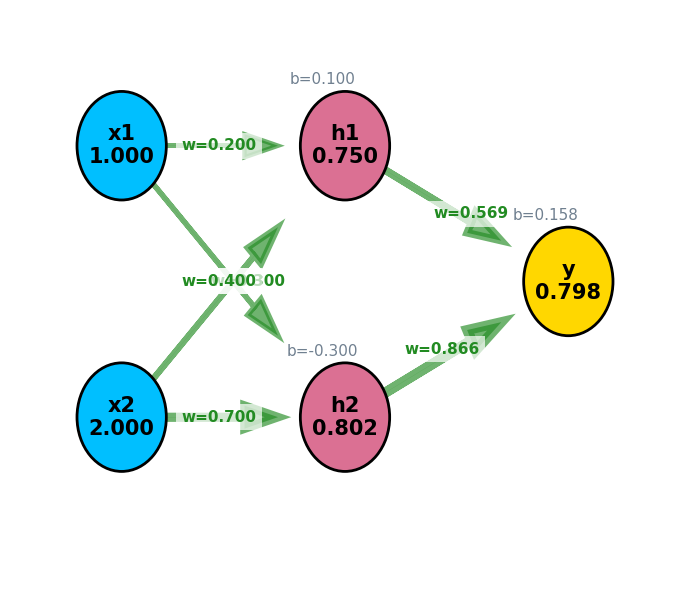

In [29]:
old_wh1y = weight_dict[('h1','y')]
old_wh2y = weight_dict[('h2','y')]
old_by = bias_dict['y']
delta_y = (y_pred - y_target) * y_pred * (1 - y_pred)
grad_wh1_y = delta_y * h1
grad_wh2_y = delta_y * h2
grad_by = delta_y
weight_dict[('h1','y')] -= eta * grad_wh1_y
weight_dict[('h2','y')] -= eta * grad_wh2_y
bias_dict['y'] -= eta * grad_by
print(f"delta_y = ({y_pred:.3f} - {y_target:.3f}) * {y_pred:.3f} * (1 - {y_pred:.3f}) = {delta_y:.6f}")
print(f"w_h1y_new = {old_wh1y:.3f} - {eta:.3f} * ({delta_y:.6f} * {h1:.3f}) = {weight_dict[('h1','y')]:.3f}")
print(f"w_h2y_new = {old_wh2y:.3f} - {eta:.3f} * ({delta_y:.6f} * {h2:.3f}) = {weight_dict[('h2','y')]:.3f}")
print(f"b_y_new = {old_by:.3f} - {eta:.3f} * {delta_y:.6f} = {bias_dict['y']:.3f}")
draw_annotated_network(node_vals, bias_dict, weight_dict)

Take a close look at the updated network parameters.

* Do you see how the output layer weights and biases have been updated by the backpropagation operation?
* We have not yet applied backprop to the hidden layer weights and biases, so these have not yet changed.
* Have the values in each of the nodes changed? If yes, why? If not, why not?

### Hidden Layer Weight and Bias Updates

We will now apply backpropagation to update the weights and biases on the first of the two nodes in the hidden layer \$w_{x1,h1}\$, \$w_{x2,h1}\$, and \$b_{h1}\$. (The expressions and procedure are completely analogous for the second node in the hidden layer, so we will not write these explicitly here but we will make the update in the code below.)

<br />

OK, so this time we need the gradients \$ \frac{\partial E}{\partial w_{h1,y}} \$, \$ \frac{\partial E}{\partial w_{h2,y}} \$, and \$ \frac{\partial E}{\partial b_y} \$.

<br />

Looking back at the forward pass equations, we see that \$E\$ is a function of \$y_{pred}\$, which is a function of \$z_y\$, which is a function of \$h_1\$, which is a function of \$z_1\$, which is a function of $w_{x1,h1}\$, \$w_{x2,h1}\$, and \$b_{h1}\$.

So we see that the further back we go in the network the more complicated and nested the expressions become.

Again, appealing to the chain rule:

<br />

$$
\frac{\partial E}{\partial w_{x1,h1}} =
\frac{\partial E}{\partial y_{pred}}
\cdot \frac{\partial y_{pred}}{\partial z_y}
\cdot \frac{\partial z_y}{\partial h_1}
\cdot \frac{\partial h_1}{\partial z_1}
\cdot \frac{\partial z_1}{\partial w_{x1,h1}}
$$

$$
\frac{\partial E}{\partial w_{x2,h1}} =
\frac{\partial E}{\partial y_{pred}}
\cdot \frac{\partial y_{pred}}{\partial z_y}
\cdot \frac{\partial z_y}{\partial h_1}
\cdot \frac{\partial h_1}{\partial z_1}
\cdot \frac{\partial z_1}{\partial w_{x2,h1}}
$$

$$
\frac{\partial E}{\partial b_{h1}} =
\frac{\partial E}{\partial y_{pred}}
\cdot \frac{\partial y_{pred}}{\partial z_y}
\cdot \frac{\partial z_y}{\partial h_1}
\cdot \frac{\partial h_1}{\partial z_1}
\cdot \frac{\partial z_1}{\partial b_{h1}}
$$

<br />

Let's collect all the forward pass and loss function equations here:

- $ E = \frac{1}{2} \left( t - y_{pred} \right)^2 $
- $ y_{pred} = \sigma(z_y) = \frac{1}{1 + e^{-z_y}} $
- $ z_y = h_1 w_{h1,y} + h_2 w_{h2,y} + b_y $
- $ h_j = \sigma(z_j) = \frac{1}{1 + e^{-z_j}} $
- $ z_1 = x_1 w_{x1,h1} + x_2 w_{x2,h1} + b_{h1} $
- $ z_2 = x_1 w_{x1,h2} + x_2 w_{x2,h2} + b_{h2} $

<br />

Now, let's take the derivatives that we need:

- \$ \frac{\partial E}{\partial y_{pred}} = y_{pred} - t \$
- \$ \frac{\partial y_{pred}}{\partial z_y} = y_{pred}(1-y_{pred}) \$
- \$ \frac{\partial z_y}{\partial h_1} = w_{h1,y} \$
- \$ \frac{\partial h_1}{\partial z_1} = h_1(1-h_1) \$
- \$ \frac{\partial z_1}{\partial w_{x1,h1}} = x_1 \$
- \$ \frac{\partial z_1}{\partial w_{x2,h1}} = x_2 \$
- \$ \frac{\partial z_1}{\partial b_{h1}} = 1 \$

<br />

For the second and fourth derivatives, remember the expression we learned above for the derivative of a sigmoid?

<br />

Now putting it all together:

$$
\frac{\partial E}{\partial w_{x1,h1}} = (y_{pred} - t)\, y_{pred}(1-y_{pred})\, w_{h1,y}\, h_1(1-h_1)\, x_1
$$

$$
\frac{\partial E}{\partial w_{x2,h1}} = (y_{pred} - t)\, y_{pred}(1-y_{pred})\, w_{h1,y}\, h_1(1-h_1)\, x_2
$$

$$
\frac{\partial E}{\partial b_{h1}} = (y_{pred} - t)\, y_{pred}(1-y_{pred})\, w_{h1,y}\, h_1(1-h_1)
$$

<br />

And defining for simplicity:

$$
\delta_{h1} = (y_{pred} - t) \cdot y_{pred}(1-y_{pred}) w_{h1,y} h_1(1-h_1)
$$

we can write compactly as:

$$
\frac{\partial E}{\partial w_{x1,h1}} = \delta_{h1} x_1 \\
\frac{\partial E}{\partial w_{x2,h1}} = \delta_{h1} x_2 \\
\frac{\partial E}{\partial b_{h1}} = \delta_{h1}
$$

<br />

And our backprop update rules:

$$
w_{x1,h1}^{new} = w_{x1,h1} - \eta \frac{\partial E}{\partial w_{x1,h1}} \\
w_{x2,h1}^{new} = w_{x2,h1} - \eta \frac{\partial E}{\partial w_{x2,h1}} \\
b_{h1}^{new} = b_{h1} - \eta \frac{\partial E}{\partial b_{h1}}
$$

become:

$$
w_{x1,h1}^{new} = w_{x1,h1} - \eta \delta_{h1} x_1 \\
w_{x2,h1}^{new} = w_{x2,h1} - \eta \delta_{h1} x_2 \\
b_{h1}^{new} = b_{h1} - \eta \delta_{h1}
$$

delta_h1 = 0.209402 * 0.569 * 0.750 * (1 - 0.750) = 0.022309
w_x1h1_new = 0.200 - 0.200 * (0.022309 * 1.0) = 0.196
w_x2h1_new = 0.400 - 0.200 * (0.022309 * 2.0) = 0.391
b_h1_new = 0.100 - 0.200 * 0.022309 = 0.096
delta_h2 = 0.209402 * 0.866 * 0.802 * (1 - 0.802) = 0.028790
w_x1h2_new = 0.300 - 0.200 * (0.028790 * 1.0) = 0.294
w_x2h2_new = 0.700 - 0.200 * (0.028790 * 2.0) = 0.688
b_h2_new = -0.300 - 0.200 * 0.028790 = -0.306


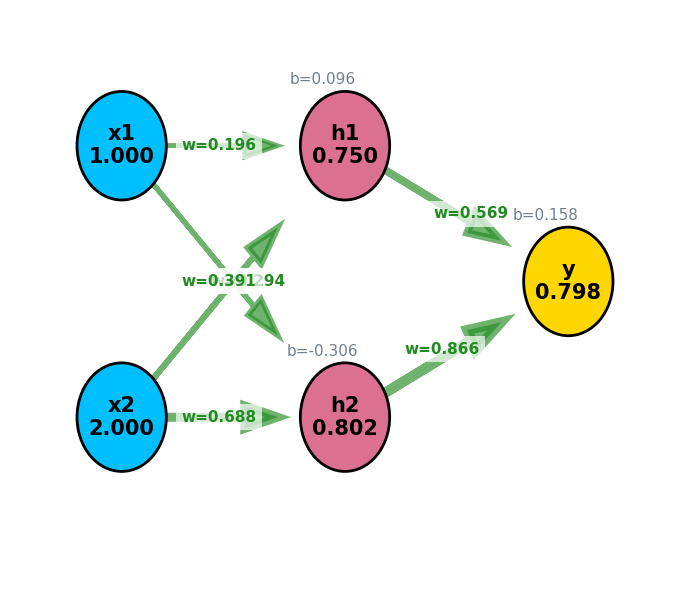

In [30]:
old_wx1h1 = weight_dict[('x1','h1')]
old_wx2h1 = weight_dict[('x2','h1')]
old_bh1 = bias_dict['h1']
old_wx1h2 = weight_dict[('x1','h2')]
old_wx2h2 = weight_dict[('x2','h2')]
old_bh2 = bias_dict['h2']
delta_h1 = delta_y * weight_dict[('h1','y')] * h1 * (1 - h1)
delta_h2 = delta_y * weight_dict[('h2','y')] * h2 * (1 - h2)
grad_wx1_h1 = delta_h1 * x1
grad_wx2_h1 = delta_h1 * x2
grad_bh1 = delta_h1
grad_wx1_h2 = delta_h2 * x1
grad_wx2_h2 = delta_h2 * x2
grad_bh2 = delta_h2
weight_dict[('x1','h1')] -= eta * grad_wx1_h1
weight_dict[('x2','h1')] -= eta * grad_wx2_h1
bias_dict['h1'] -= eta * grad_bh1
weight_dict[('x1','h2')] -= eta * grad_wx1_h2
weight_dict[('x2','h2')] -= eta * grad_wx2_h2
bias_dict['h2'] -= eta * grad_bh2
print(f"delta_h1 = {delta_y:.6f} * {weight_dict[('h1','y')]:.3f} * {h1:.3f} * (1 - {h1:.3f}) = {delta_h1:.6f}")
print(f"w_x1h1_new = {old_wx1h1:.3f} - {eta:.3f} * ({delta_h1:.6f} * {x1:.1f}) = {weight_dict[('x1','h1')]:.3f}")
print(f"w_x2h1_new = {old_wx2h1:.3f} - {eta:.3f} * ({delta_h1:.6f} * {x2:.1f}) = {weight_dict[('x2','h1')]:.3f}")
print(f"b_h1_new = {old_bh1:.3f} - {eta:.3f} * {delta_h1:.6f} = {bias_dict['h1']:.3f}")
print(f"delta_h2 = {delta_y:.6f} * {weight_dict[('h2','y')]:.3f} * {h2:.3f} * (1 - {h2:.3f}) = {delta_h2:.6f}")
print(f"w_x1h2_new = {old_wx1h2:.3f} - {eta:.3f} * ({delta_h2:.6f} * {x1:.1f}) = {weight_dict[('x1','h2')]:.3f}")
print(f"w_x2h2_new = {old_wx2h2:.3f} - {eta:.3f} * ({delta_h2:.6f} * {x2:.1f}) = {weight_dict[('x2','h2')]:.3f}")
print(f"b_h2_new = {old_bh2:.3f} - {eta:.3f} * {delta_h2:.6f} = {bias_dict['h2']:.3f}")
draw_annotated_network(node_vals, bias_dict, weight_dict)

Let's inspect the updated network.

* Do you see how the hidden layer weights and biases have been updated by backprop?
* Are there any more network parameters to update?
* Why does the input layer not have any weights or biases?

## Training step complete! 🎉

Let's redraw the updated the network with the new weights and biases reflecting one pass of backpropagation learning.

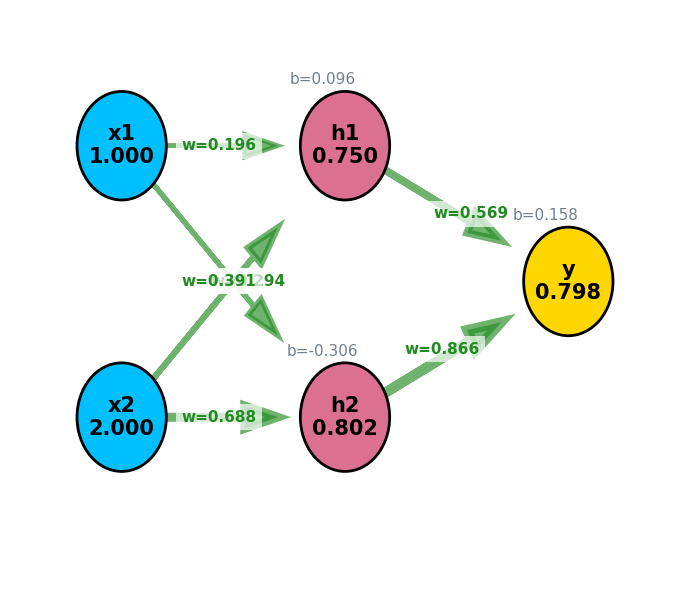

In [31]:
draw_annotated_network(node_vals, bias_dict, weight_dict)

# Loss Function

Remember our loss function (aka error fucntion) we will use to evaluate the network performance:

$$
E = \frac{1}{2}(y_{pred} - y_{target})^2
$$

Let's run that calculation to see how well the network performs with the updated weights and biases.

In [32]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Compute hidden layer preactivations
z1 = float(node_vals['x1']) * weight_dict[('x1','h1')] + float(node_vals['x2']) * weight_dict[('x2','h1')] + bias_dict['h1']
z2 = float(node_vals['x1']) * weight_dict[('x1','h2')] + float(node_vals['x2']) * weight_dict[('x2','h2')] + bias_dict['h2']

# Activations for hidden layer
h1 = sigmoid(z1)
h2 = sigmoid(z2)

# Compute output preactivation and activation
z_y = h1 * weight_dict[('h1','y')] + h2 * weight_dict[('h2','y')] + bias_dict['y']
y_pred = sigmoid(z_y)

print("y_pred =", y_pred)

y_pred = 0.7810928951271621


In [33]:
E = 0.5 * (y_pred-y_target)**2
print(f"E = 0.5 * ({y_pred:.3f} - {y_target:.3f})^2 = {E:.5f}")

E = 0.5 * (0.781 - -0.500)^2 = 0.82060


How did we do?

* Did the error improve (i.e., get smaller) after our single pass of backpropagation?
* How could we make the error even smaller?
* What would be the next steps in network training?
* How might we further improve network performance?